<a href="https://colab.research.google.com/github/pkky/Glebokie-uczenie/blob/main/Praca_domowa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A regression example
Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# install optuna
! pip install optuna

     |████████████████████████████████| 286kB 14.7MB/s 
     |████████████████████████████████| 163kB 27.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 481kB 16.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 133kB 29.4MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=1405eabed4113d7d4b6e330a0d35ee3ad1d27c5da6e1682ecd2e3538448510a3
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=8712433521fcb26376aada5d79d33f5a35ec50f036fa33e00492a232da58a1ed
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sh

In [3]:
import optuna


1-dimensional data

In [4]:
def funct(x):
  return (x**3+2**x*2+10+np.cos(x)+np.log(x**3))
size = 90
low=0
high=15
error=15

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(90,) (90,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

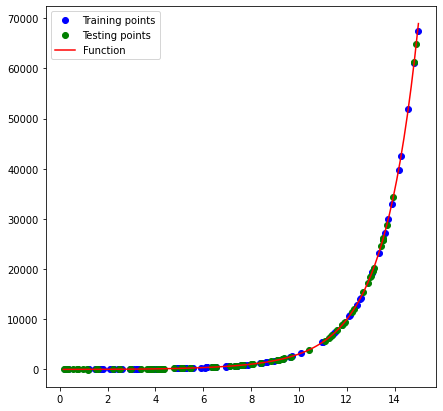

In [5]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show

#Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:

In [6]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [7]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers

In [8]:
def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [9]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=300)

study.best_params

[I 2021-01-15 21:17:32,012] A new study created in memory with name: no-name-e657a838-1ff9-4c49-b719-3215acb678c7
[I 2021-01-15 21:17:32,016] A new study created in memory with name: no-name-cc2e33c5-ccfd-41ad-bf6e-9f30d4c6ca66


3/3 [==============================] - 0s 6ms/step - loss: 0.0209 - mse: 0.0209


[I 2021-01-15 21:18:17,669] Trial 0 finished with value: 0.02094041183590889 and parameters: {'units': 1292.0, 'dropout': 0.016841470178106055, 'lr': 0.0010289716354085232, 'activation': 'relu'}. Best is trial 0 with value: 0.02094041183590889.


Epoch 00224: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0246 - mse: 0.0246


[I 2021-01-15 21:18:38,818] Trial 1 finished with value: 0.024586062878370285 and parameters: {'units': 1300.0, 'dropout': 0.023238290790095095, 'lr': 0.000767466333244577, 'activation': 'relu'}. Best is trial 0 with value: 0.02094041183590889.


3/3 [==============================] - 0s 2ms/step - loss: 0.1430 - mse: 0.1430


[I 2021-01-15 21:19:11,645] Trial 2 finished with value: 0.14300616085529327 and parameters: {'units': 372.0, 'dropout': 0.21413494964600827, 'lr': 0.001076293504045117, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.02094041183590889.


Epoch 00062: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.7406 - mse: 0.7406


[I 2021-01-15 21:19:16,946] Trial 3 finished with value: 0.7405714988708496 and parameters: {'units': 733.0, 'dropout': 0.3793116541565764, 'lr': 0.000653695409480592, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.02094041183590889.


Epoch 00423: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0200 - mse: 0.0200


[I 2021-01-15 21:19:55,679] Trial 4 finished with value: 0.019986987113952637 and parameters: {'units': 1250.0, 'dropout': 0.0095440830357848, 'lr': 0.0012924095270406251, 'activation': 'relu'}. Best is trial 4 with value: 0.019986987113952637.


Epoch 00272: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0099 - mse: 0.0099


[I 2021-01-15 21:20:19,419] Trial 5 finished with value: 0.009928434155881405 and parameters: {'units': 1181.0, 'dropout': 0.22363005264688163, 'lr': 0.0005001641237175564, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00107: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.7871 - mse: 0.7871


[I 2021-01-15 21:20:33,227] Trial 6 finished with value: 0.7870738506317139 and parameters: {'units': 1876.0, 'dropout': 0.28725533129671227, 'lr': 0.001966851576816515, 'activation': 'sigmoid'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00251: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0265 - mse: 0.0265


[I 2021-01-15 21:20:53,211] Trial 7 finished with value: 0.02653518319129944 and parameters: {'units': 865.0, 'dropout': 0.27182087268069954, 'lr': 0.001317645049708125, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00186: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.3909 - mse: 0.3909


[I 2021-01-15 21:21:09,335] Trial 8 finished with value: 0.39094680547714233 and parameters: {'units': 1081.0, 'dropout': 0.30188591844108814, 'lr': 0.0005676198267497335, 'activation': 'linear'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00245: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0371 - mse: 0.0371


[I 2021-01-15 21:21:35,059] Trial 9 finished with value: 0.03713899850845337 and parameters: {'units': 1560.0, 'dropout': 0.4643357854008271, 'lr': 0.0014987668806653674, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00052: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.4229 - mse: 0.4229


[I 2021-01-15 21:21:38,912] Trial 10 finished with value: 0.42285680770874023 and parameters: {'units': 160.0, 'dropout': 0.14224286004424647, 'lr': 0.0005357985551655536, 'activation': 'linear'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00200: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0505 - mse: 0.0505


[I 2021-01-15 21:22:03,067] Trial 11 finished with value: 0.05052521079778671 and parameters: {'units': 1777.0, 'dropout': 0.11931668756777744, 'lr': 0.0017147506318591175, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00289: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0249 - mse: 0.0249


[I 2021-01-15 21:22:24,767] Trial 12 finished with value: 0.024901961907744408 and parameters: {'units': 675.0, 'dropout': 0.0957834650969428, 'lr': 0.0008301875938189385, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00237: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0334 - mse: 0.0334


[I 2021-01-15 21:22:52,492] Trial 13 finished with value: 0.03342488035559654 and parameters: {'units': 1454.0, 'dropout': 0.48403107134869394, 'lr': 0.001293256654720808, 'activation': 'relu'}. Best is trial 5 with value: 0.009928434155881405.


Epoch 00303: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0072 - mse: 0.0072


[I 2021-01-15 21:23:18,483] Trial 14 finished with value: 0.0071735018864274025 and parameters: {'units': 1051.0, 'dropout': 0.38006558806381185, 'lr': 0.0011962181883748396, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00092: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.4004 - mse: 0.4004


[I 2021-01-15 21:23:26,576] Trial 15 finished with value: 0.40044844150543213 and parameters: {'units': 995.0, 'dropout': 0.3845421486870949, 'lr': 0.0008657123270285644, 'activation': 'linear'}. Best is trial 14 with value: 0.0071735018864274025.


3/3 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097


[I 2021-01-15 21:23:59,950] Trial 16 finished with value: 0.009744116105139256 and parameters: {'units': 505.0, 'dropout': 0.2043535112738637, 'lr': 0.0011119429450474894, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


3/3 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106


[I 2021-01-15 21:24:34,451] Trial 17 finished with value: 0.010645943693816662 and parameters: {'units': 508.0, 'dropout': 0.36458250382617563, 'lr': 0.001128669795392567, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


3/3 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163


[I 2021-01-15 21:25:03,881] Trial 18 finished with value: 0.01625620573759079 and parameters: {'units': 62.0, 'dropout': 0.43932069219682457, 'lr': 0.0015529473070085501, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00100: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.3930 - mse: 0.3930


[I 2021-01-15 21:25:10,987] Trial 19 finished with value: 0.3929505944252014 and parameters: {'units': 344.0, 'dropout': 0.1713854699225476, 'lr': 0.00091179105620273, 'activation': 'linear'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00084: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.9761 - mse: 0.9761


[I 2021-01-15 21:25:17,551] Trial 20 finished with value: 0.9760593175888062 and parameters: {'units': 625.0, 'dropout': 0.32870905135256523, 'lr': 0.000708459827650672, 'activation': 'sigmoid'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00385: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0097 - mse: 0.0097


[I 2021-01-15 21:25:49,134] Trial 21 finished with value: 0.009721011854708195 and parameters: {'units': 1072.0, 'dropout': 0.22234854462825251, 'lr': 0.0011820835930839552, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00194: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0385 - mse: 0.0385


[I 2021-01-15 21:26:04,594] Trial 22 finished with value: 0.038518138229846954 and parameters: {'units': 908.0, 'dropout': 0.2014776835054411, 'lr': 0.0011895319896684632, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00225: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0191 - mse: 0.0191


[I 2021-01-15 21:26:21,688] Trial 23 finished with value: 0.01909184455871582 and parameters: {'units': 845.0, 'dropout': 0.07659665656098211, 'lr': 0.0009587474403640543, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00173: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0476 - mse: 0.0476


[I 2021-01-15 21:26:40,523] Trial 24 finished with value: 0.04755876213312149 and parameters: {'units': 1553.0, 'dropout': 0.2423481407616879, 'lr': 0.0014799239299430648, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00212: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0292 - mse: 0.0292


[I 2021-01-15 21:26:59,082] Trial 25 finished with value: 0.029151635244488716 and parameters: {'units': 1098.0, 'dropout': 0.16078857260350776, 'lr': 0.001195389730081479, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00431: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100


[I 2021-01-15 21:27:27,645] Trial 26 finished with value: 0.009999890811741352 and parameters: {'units': 461.0, 'dropout': 0.41836993929726496, 'lr': 0.0010028019692323673, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


Epoch 00191: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0870 - mse: 0.0870


[I 2021-01-15 21:27:47,141] Trial 27 finished with value: 0.08703894913196564 and parameters: {'units': 1438.0, 'dropout': 0.3306162513957084, 'lr': 0.0017047237820737888, 'activation': 'relu'}. Best is trial 14 with value: 0.0071735018864274025.


3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2021-01-15 21:28:17,869] Trial 28 finished with value: 0.0030319453217089176 and parameters: {'units': 234.0, 'dropout': 0.20036207152823232, 'lr': 0.0013848275814811791, 'activation': 'relu'}. Best is trial 28 with value: 0.0030319453217089176.


Epoch 00240: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0467 - mse: 0.0467


[I 2021-01-15 21:28:40,893] Trial 29 finished with value: 0.046725910156965256 and parameters: {'units': 1336.0, 'dropout': 0.2570886583802089, 'lr': 0.00196662058323832, 'activation': 'relu'}. Best is trial 28 with value: 0.0030319453217089176.


Epoch 00245: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0354 - mse: 0.0354


[I 2021-01-15 21:29:00,651] Trial 30 finished with value: 0.03543718531727791 and parameters: {'units': 952.0, 'dropout': 0.17524585767652467, 'lr': 0.0013800190584886004, 'activation': 'relu'}. Best is trial 28 with value: 0.0030319453217089176.


3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2021-01-15 21:29:30,717] Trial 31 finished with value: 0.0028482682537287474 and parameters: {'units': 210.0, 'dropout': 0.20428104482518272, 'lr': 0.0010579713147948957, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030


[I 2021-01-15 21:30:02,048] Trial 32 finished with value: 0.0029666575137525797 and parameters: {'units': 218.0, 'dropout': 0.2476909242649969, 'lr': 0.0010347619513058493, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067


[I 2021-01-15 21:30:33,396] Trial 33 finished with value: 0.006734942551702261 and parameters: {'units': 166.0, 'dropout': 0.058662251730776105, 'lr': 0.001003387610655214, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047


[I 2021-01-15 21:31:03,513] Trial 34 finished with value: 0.004656556528061628 and parameters: {'units': 192.0, 'dropout': 0.04704202776156716, 'lr': 0.0010136219092319629, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


Epoch 00215: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.5348 - mse: 0.5348


[I 2021-01-15 21:31:17,032] Trial 35 finished with value: 0.5348487496376038 and parameters: {'units': 267.0, 'dropout': 0.12072693094644985, 'lr': 0.0007706498484170048, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 0.0034


[I 2021-01-15 21:31:46,222] Trial 36 finished with value: 0.0034242768306285143 and parameters: {'units': 61.0, 'dropout': 0.025173375992431857, 'lr': 0.0010322080690976705, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068


[I 2021-01-15 21:32:16,338] Trial 37 finished with value: 0.006756776478141546 and parameters: {'units': 27.0, 'dropout': 0.007432230334020989, 'lr': 0.0010657191511416746, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 2ms/step - loss: 0.2497 - mse: 0.2497


[I 2021-01-15 21:32:45,531] Trial 38 finished with value: 0.24965165555477142 and parameters: {'units': 49.0, 'dropout': 0.24051033569650604, 'lr': 0.0009053526799098158, 'activation': 'sigmoid'}. Best is trial 31 with value: 0.0028482682537287474.


Epoch 00478: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041


[I 2021-01-15 21:33:17,322] Trial 39 finished with value: 0.004095137119293213 and parameters: {'units': 361.0, 'dropout': 0.18768681174994206, 'lr': 0.0007688524976928071, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050


[I 2021-01-15 21:33:48,691] Trial 40 finished with value: 0.005003735888749361 and parameters: {'units': 265.0, 'dropout': 0.3046377934541731, 'lr': 0.0013863212268912443, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221


[I 2021-01-15 21:34:20,288] Trial 41 finished with value: 0.022130949422717094 and parameters: {'units': 381.0, 'dropout': 0.18883969992757196, 'lr': 0.0007871744875629691, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070


[I 2021-01-15 21:34:51,152] Trial 42 finished with value: 0.00701140146702528 and parameters: {'units': 119.0, 'dropout': 0.26772575726800996, 'lr': 0.0007178144252774118, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143


[I 2021-01-15 21:35:21,440] Trial 43 finished with value: 0.014269760809838772 and parameters: {'units': 262.0, 'dropout': 0.15757553634480445, 'lr': 0.0006141473230945442, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


Epoch 00453: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0177 - mse: 0.0177


[I 2021-01-15 21:35:51,046] Trial 44 finished with value: 0.017692526802420616 and parameters: {'units': 388.0, 'dropout': 0.12919022533914087, 'lr': 0.000908721587033007, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


Epoch 00088: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.3994 - mse: 0.3994


[I 2021-01-15 21:35:57,611] Trial 45 finished with value: 0.3993709981441498 and parameters: {'units': 619.0, 'dropout': 0.2344454181750092, 'lr': 0.00108792797871334, 'activation': 'linear'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 2ms/step - loss: 0.1227 - mse: 0.1227


[I 2021-01-15 21:36:28,299] Trial 46 finished with value: 0.12267062067985535 and parameters: {'units': 15.0, 'dropout': 0.2806456363396465, 'lr': 0.0008281431706706174, 'activation': 'relu'}. Best is trial 31 with value: 0.0028482682537287474.


3/3 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023


[I 2021-01-15 21:36:58,237] Trial 47 finished with value: 0.0022672538179904222 and parameters: {'units': 220.0, 'dropout': 0.09253624728031248, 'lr': 0.0006639263374630661, 'activation': 'relu'}. Best is trial 47 with value: 0.0022672538179904222.


3/3 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012    


[I 2021-01-15 21:37:28,600] Trial 48 finished with value: 0.001231996575370431 and parameters: {'units': 118.0, 'dropout': 0.03578195664304107, 'lr': 0.0009524380292090216, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00218: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4513 - mse: 0.4513


[I 2021-01-15 21:37:43,380] Trial 49 finished with value: 0.45133429765701294 and parameters: {'units': 263.0, 'dropout': 0.10366296010876372, 'lr': 0.0006384070828772255, 'activation': 'sigmoid'}. Best is trial 48 with value: 0.001231996575370431.


3/3 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042


[I 2021-01-15 21:38:12,715] Trial 50 finished with value: 0.004246089607477188 and parameters: {'units': 137.0, 'dropout': 0.08089218856389366, 'lr': 0.0005069019569778038, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124


[I 2021-01-15 21:38:43,567] Trial 51 finished with value: 0.012402352876961231 and parameters: {'units': 88.0, 'dropout': 0.0335768048262659, 'lr': 0.0009434706158687001, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00405: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064


[I 2021-01-15 21:39:08,714] Trial 52 finished with value: 0.006365338806062937 and parameters: {'units': 197.0, 'dropout': 0.01884914281643734, 'lr': 0.0012381349388720846, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00323: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076


[I 2021-01-15 21:39:29,897] Trial 53 finished with value: 0.00758908037096262 and parameters: {'units': 508.0, 'dropout': 0.05927962850241564, 'lr': 0.001043012201864787, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


3/3 [==============================] - 0s 3ms/step - loss: 0.2078 - mse: 0.2078


[I 2021-01-15 21:39:59,998] Trial 54 finished with value: 0.20780444145202637 and parameters: {'units': 11.0, 'dropout': 0.03553384209948726, 'lr': 0.0008474817085142335, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00097: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3926 - mse: 0.3926


[I 2021-01-15 21:40:07,058] Trial 55 finished with value: 0.39260101318359375 and parameters: {'units': 449.0, 'dropout': 0.09413226278784727, 'lr': 0.0011313566219095484, 'activation': 'linear'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00478: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027    


[I 2021-01-15 21:40:36,670] Trial 56 finished with value: 0.0027449922636151314 and parameters: {'units': 301.0, 'dropout': 0.14729010674808998, 'lr': 0.0009594696715462957, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


3/3 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016


[I 2021-01-15 21:41:08,821] Trial 57 finished with value: 0.0015780142275616527 and parameters: {'units': 318.0, 'dropout': 0.1467286590509377, 'lr': 0.0005588294394912748, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


Epoch 00387: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061


[I 2021-01-15 21:41:36,925] Trial 58 finished with value: 0.006089766975492239 and parameters: {'units': 756.0, 'dropout': 0.1451643961014427, 'lr': 0.0005813158255476114, 'activation': 'relu'}. Best is trial 48 with value: 0.001231996575370431.


3/3 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010    


[I 2021-01-15 21:42:10,177] Trial 59 finished with value: 0.0010137122590094805 and parameters: {'units': 561.0, 'dropout': 0.14198961620717448, 'lr': 0.0005284017085360616, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00441: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0063 - mse: 0.0063


[I 2021-01-15 21:42:40,333] Trial 60 finished with value: 0.006290084682404995 and parameters: {'units': 567.0, 'dropout': 0.10786876316530851, 'lr': 0.0005336448086496284, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00455: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0117 - mse: 0.0117


[I 2021-01-15 21:43:09,832] Trial 61 finished with value: 0.011686102487146854 and parameters: {'units': 435.0, 'dropout': 0.13533165170804723, 'lr': 0.0005572714862936551, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00494: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0161 - mse: 0.0161


[I 2021-01-15 21:43:41,823] Trial 62 finished with value: 0.016059869900345802 and parameters: {'units': 336.0, 'dropout': 0.15794825217344596, 'lr': 0.0006943046728059525, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042


[I 2021-01-15 21:44:13,664] Trial 63 finished with value: 0.004170882981270552 and parameters: {'units': 313.0, 'dropout': 0.07835936696523757, 'lr': 0.0005096221306221546, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058


[I 2021-01-15 21:44:43,040] Trial 64 finished with value: 0.0057918415404856205 and parameters: {'units': 147.0, 'dropout': 0.22096609934772565, 'lr': 0.0006177213598884445, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00390: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0207 - mse: 0.0207


[I 2021-01-15 21:45:11,964] Trial 65 finished with value: 0.02069123275578022 and parameters: {'units': 727.0, 'dropout': 0.18246254476400514, 'lr': 0.0009601636455917293, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055


[I 2021-01-15 21:45:42,619] Trial 66 finished with value: 0.005460458341985941 and parameters: {'units': 314.0, 'dropout': 0.1448732870342242, 'lr': 0.0005867889663783328, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052


[I 2021-01-15 21:46:13,244] Trial 67 finished with value: 0.005155890714377165 and parameters: {'units': 210.0, 'dropout': 0.20832730061569205, 'lr': 0.0005432230456080146, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00196: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0253 - mse: 0.0253


[I 2021-01-15 21:46:39,912] Trial 68 finished with value: 0.02527756243944168 and parameters: {'units': 2041.0, 'dropout': 0.12239048471891834, 'lr': 0.0006702981694737593, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00112: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3941 - mse: 0.3941


[I 2021-01-15 21:46:48,085] Trial 69 finished with value: 0.3941177725791931 and parameters: {'units': 556.0, 'dropout': 0.16675085104724202, 'lr': 0.0011505294313609116, 'activation': 'linear'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00334: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062


[I 2021-01-15 21:47:09,979] Trial 70 finished with value: 0.006193792913109064 and parameters: {'units': 409.0, 'dropout': 0.11048585340961792, 'lr': 0.0009711885554452099, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00397: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157


[I 2021-01-15 21:47:34,734] Trial 71 finished with value: 0.0156503114849329 and parameters: {'units': 235.0, 'dropout': 0.1956332981411949, 'lr': 0.0016706827899018542, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 2ms/step - loss: 0.0144 - mse: 0.0144


[I 2021-01-15 21:48:04,092] Trial 72 finished with value: 0.01437793206423521 and parameters: {'units': 106.0, 'dropout': 0.2080323140035539, 'lr': 0.0018927880252187872, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00401: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031


[I 2021-01-15 21:48:29,797] Trial 73 finished with value: 0.003119402565062046 and parameters: {'units': 301.0, 'dropout': 0.2238132505333693, 'lr': 0.0013400305047156567, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039


[I 2021-01-15 21:49:00,901] Trial 74 finished with value: 0.003913261462002993 and parameters: {'units': 201.0, 'dropout': 0.14927601239937496, 'lr': 0.000805710715505337, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041


[I 2021-01-15 21:49:31,078] Trial 75 finished with value: 0.004050832241773605 and parameters: {'units': 156.0, 'dropout': 0.2530217956046558, 'lr': 0.0012544688781364495, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


Epoch 00059: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.5110 - mse: 1.5110


[I 2021-01-15 21:49:35,873] Trial 76 finished with value: 1.5109864473342896 and parameters: {'units': 497.0, 'dropout': 0.08723267379856936, 'lr': 0.001455247973623797, 'activation': 'sigmoid'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040


[I 2021-01-15 21:50:06,133] Trial 77 finished with value: 0.004005670081824064 and parameters: {'units': 90.0, 'dropout': 0.17484317331455435, 'lr': 0.0008836699994787045, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058


[I 2021-01-15 21:50:37,433] Trial 78 finished with value: 0.005782584194093943 and parameters: {'units': 366.0, 'dropout': 0.13311891988192012, 'lr': 0.0010524231820548268, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012    


[I 2021-01-15 21:51:09,154] Trial 79 finished with value: 0.001227181637659669 and parameters: {'units': 240.0, 'dropout': 0.05750867295879934, 'lr': 0.0005203255955661169, 'activation': 'relu'}. Best is trial 59 with value: 0.0010137122590094805.


3/3 [==============================] - 0s 3ms/step - loss: 9.9379e-04 - mse: 9.9379e-04


[I 2021-01-15 21:51:39,452] Trial 80 finished with value: 0.0009937944123521447 and parameters: {'units': 301.0, 'dropout': 0.05863196134607505, 'lr': 0.0005263759370975681, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2021-01-15 21:52:11,191] Trial 81 finished with value: 0.005345294252038002 and parameters: {'units': 330.0, 'dropout': 0.05599437466662332, 'lr': 0.0005187724876656002, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0122 - mse: 0.0122


[I 2021-01-15 21:52:43,390] Trial 82 finished with value: 0.01222879346460104 and parameters: {'units': 279.0, 'dropout': 0.06023709197411161, 'lr': 0.0005618227177566504, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0146 - mse: 0.0146


[I 2021-01-15 21:53:16,208] Trial 83 finished with value: 0.014552866108715534 and parameters: {'units': 408.0, 'dropout': 0.06995897614731951, 'lr': 0.0007379098897545937, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0157 - mse: 0.0157


[I 2021-01-15 21:53:47,413] Trial 84 finished with value: 0.015671486034989357 and parameters: {'units': 219.0, 'dropout': 0.03581549700124613, 'lr': 0.0005271684616077379, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2021-01-15 21:54:18,077] Trial 85 finished with value: 0.003239214653149247 and parameters: {'units': 127.0, 'dropout': 0.0014044572953521503, 'lr': 0.0005019384191273123, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0271 - mse: 0.0271


[I 2021-01-15 21:54:47,937] Trial 86 finished with value: 0.027126023545861244 and parameters: {'units': 52.0, 'dropout': 0.0911973741790845, 'lr': 0.0005932973015967941, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00247: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0233 - mse: 0.0233


[I 2021-01-15 21:55:04,995] Trial 87 finished with value: 0.0232512466609478 and parameters: {'units': 462.0, 'dropout': 0.11338380903586587, 'lr': 0.0010891195399381137, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.1539 - mse: 0.1539


[I 2021-01-15 21:55:34,973] Trial 88 finished with value: 0.1538703441619873 and parameters: {'units': 8.0, 'dropout': 0.0491460070774027, 'lr': 0.0005440790932303186, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086


[I 2021-01-15 21:56:04,415] Trial 89 finished with value: 0.008605270646512508 and parameters: {'units': 168.0, 'dropout': 0.07170932856760039, 'lr': 0.0009910447188675336, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00183: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.3963 - mse: 0.3963


[I 2021-01-15 21:56:17,130] Trial 90 finished with value: 0.3962654173374176 and parameters: {'units': 563.0, 'dropout': 0.10402088119386978, 'lr': 0.0009246138052906943, 'activation': 'linear'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066


[I 2021-01-15 21:56:48,947] Trial 91 finished with value: 0.006560107227414846 and parameters: {'units': 246.0, 'dropout': 0.26273247943255795, 'lr': 0.0006389719815869017, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00258: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0286 - mse: 0.0286


[I 2021-01-15 21:57:05,645] Trial 92 finished with value: 0.028598112985491753 and parameters: {'units': 287.0, 'dropout': 0.0223945156251698, 'lr': 0.0016058705705450467, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 5ms/step - loss: 0.0013 - mse: 0.0013    


[I 2021-01-15 21:57:36,801] Trial 93 finished with value: 0.001326487516053021 and parameters: {'units': 362.0, 'dropout': 0.23042548556148, 'lr': 0.0008681505264684453, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042


[I 2021-01-15 21:58:07,543] Trial 94 finished with value: 0.004203141201287508 and parameters: {'units': 364.0, 'dropout': 0.24611905771942316, 'lr': 0.0008758678396619896, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111


[I 2021-01-15 21:58:39,159] Trial 95 finished with value: 0.01105863880366087 and parameters: {'units': 191.0, 'dropout': 0.232319600912539, 'lr': 0.0010223529723943907, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048


[I 2021-01-15 21:59:11,077] Trial 96 finished with value: 0.004753440152853727 and parameters: {'units': 338.0, 'dropout': 0.29524734400818803, 'lr': 0.0009285516837163485, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00271: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.4315 - mse: 0.4315


[I 2021-01-15 21:59:29,970] Trial 97 finished with value: 0.43148234486579895 and parameters: {'units': 467.0, 'dropout': 0.18233623428240353, 'lr': 0.0006021681660595084, 'activation': 'sigmoid'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0112 - mse: 0.0112


[I 2021-01-15 22:00:03,462] Trial 98 finished with value: 0.011204754002392292 and parameters: {'units': 415.0, 'dropout': 0.044421794281686404, 'lr': 0.000569210608196411, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00344: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0120 - mse: 0.0120


[I 2021-01-15 22:00:27,804] Trial 99 finished with value: 0.011977169662714005 and parameters: {'units': 623.0, 'dropout': 0.010600072386734882, 'lr': 0.0009818715499198786, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0442 - mse: 0.0442


[I 2021-01-15 22:00:58,876] Trial 100 finished with value: 0.04415670782327652 and parameters: {'units': 243.0, 'dropout': 0.12515093349494258, 'lr': 0.001102574772772128, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0167 - mse: 0.0167


[I 2021-01-15 22:01:28,912] Trial 101 finished with value: 0.016654232516884804 and parameters: {'units': 88.0, 'dropout': 0.19896276113573846, 'lr': 0.0005173106807498168, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00470: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092


[I 2021-01-15 22:01:58,093] Trial 102 finished with value: 0.00921397004276514 and parameters: {'units': 165.0, 'dropout': 0.16883371528810548, 'lr': 0.0008188120163026035, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00481: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045


[I 2021-01-15 22:02:28,439] Trial 103 finished with value: 0.004544236697256565 and parameters: {'units': 298.0, 'dropout': 0.21405022863402284, 'lr': 0.0010602662840423908, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00476: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048


[I 2021-01-15 22:02:56,982] Trial 104 finished with value: 0.004816957283765078 and parameters: {'units': 226.0, 'dropout': 0.27700801082008975, 'lr': 0.0011589351446706724, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0057 - mse: 0.0057


[I 2021-01-15 22:03:30,682] Trial 105 finished with value: 0.005669784732162952 and parameters: {'units': 377.0, 'dropout': 0.23151395218135076, 'lr': 0.0005545683737196059, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0038 - mse: 0.0038


[I 2021-01-15 22:04:00,001] Trial 106 finished with value: 0.0037616556510329247 and parameters: {'units': 121.0, 'dropout': 0.19234278596869145, 'lr': 0.0007474733263480313, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0072 - mse: 0.0072


[I 2021-01-15 22:04:31,871] Trial 107 finished with value: 0.0071712578646838665 and parameters: {'units': 269.0, 'dropout': 0.15611974571074796, 'lr': 0.0009519061581509744, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00500: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104


[I 2021-01-15 22:05:02,962] Trial 108 finished with value: 0.010391375981271267 and parameters: {'units': 194.0, 'dropout': 0.0656497084886988, 'lr': 0.000905259637688467, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201


[I 2021-01-15 22:05:33,154] Trial 109 finished with value: 0.020143765956163406 and parameters: {'units': 64.0, 'dropout': 0.13898313491740502, 'lr': 0.0005765938281338601, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00393: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0219 - mse: 0.0219


[I 2021-01-15 22:05:57,534] Trial 110 finished with value: 0.021895745769143105 and parameters: {'units': 328.0, 'dropout': 0.10015504707116323, 'lr': 0.0008504393807867732, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00437: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0270 - mse: 0.0270


[I 2021-01-15 22:06:25,859] Trial 111 finished with value: 0.02696256898343563 and parameters: {'units': 305.0, 'dropout': 0.23794317255680705, 'lr': 0.001352630063573323, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00482: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0331 - mse: 0.0331


[I 2021-01-15 22:06:56,412] Trial 112 finished with value: 0.03312018886208534 and parameters: {'units': 271.0, 'dropout': 0.08023904322719633, 'lr': 0.0013639938747529773, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00269: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0351 - mse: 0.0351


[I 2021-01-15 22:07:19,381] Trial 113 finished with value: 0.03513415530323982 and parameters: {'units': 1176.0, 'dropout': 0.21384435918912278, 'lr': 0.0015424479343518441, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090


[I 2021-01-15 22:07:50,788] Trial 114 finished with value: 0.00897950492799282 and parameters: {'units': 229.0, 'dropout': 0.21948511404198603, 'lr': 0.0010144150174418178, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00302: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291


[I 2021-01-15 22:08:10,990] Trial 115 finished with value: 0.029082968831062317 and parameters: {'units': 520.0, 'dropout': 0.2545236072390375, 'lr': 0.0014616099986002903, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012    


[I 2021-01-15 22:08:42,613] Trial 116 finished with value: 0.0011637721909210086 and parameters: {'units': 161.0, 'dropout': 0.22877255680097092, 'lr': 0.001285526626094272, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012    


[I 2021-01-15 22:09:13,392] Trial 117 finished with value: 0.001192830502986908 and parameters: {'units': 143.0, 'dropout': 0.20209598262156508, 'lr': 0.001307364596279152, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0115 - mse: 0.0115


[I 2021-01-15 22:09:43,409] Trial 118 finished with value: 0.011494372971355915 and parameters: {'units': 147.0, 'dropout': 0.2255387377874006, 'lr': 0.0012521767864712339, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00055: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.4179 - mse: 0.4179


[I 2021-01-15 22:09:47,429] Trial 119 finished with value: 0.4178934693336487 and parameters: {'units': 86.0, 'dropout': 0.1808322855126576, 'lr': 0.0005003820515616266, 'activation': 'linear'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025


[I 2021-01-15 22:10:18,371] Trial 120 finished with value: 0.0025435013230890036 and parameters: {'units': 180.0, 'dropout': 0.26651890881779594, 'lr': 0.000665587890795118, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141


[I 2021-01-15 22:10:48,663] Trial 121 finished with value: 0.014131953939795494 and parameters: {'units': 179.0, 'dropout': 0.2950131963529776, 'lr': 0.001280802134712442, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0285 - mse: 0.0285


[I 2021-01-15 22:11:20,022] Trial 122 finished with value: 0.028517693281173706 and parameters: {'units': 40.0, 'dropout': 0.30873875948639345, 'lr': 0.001211687966680856, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018    


[I 2021-01-15 22:11:51,818] Trial 123 finished with value: 0.0018286076374351978 and parameters: {'units': 128.0, 'dropout': 0.27137569118179306, 'lr': 0.0013094102832088257, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00460: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0221 - mse: 0.0221


[I 2021-01-15 22:12:20,687] Trial 124 finished with value: 0.022097347304224968 and parameters: {'units': 131.0, 'dropout': 0.28647211140106477, 'lr': 0.001429862730590844, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075


[I 2021-01-15 22:12:52,289] Trial 125 finished with value: 0.007480092812329531 and parameters: {'units': 106.0, 'dropout': 0.2618209911076235, 'lr': 0.0006914575321589001, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.0034


[I 2021-01-15 22:13:22,710] Trial 126 finished with value: 0.0034424206241965294 and parameters: {'units': 183.0, 'dropout': 0.2714657071552032, 'lr': 0.0013088123286648366, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030    


[I 2021-01-15 22:13:54,673] Trial 127 finished with value: 0.0029777123127132654 and parameters: {'units': 233.0, 'dropout': 0.03180421023817443, 'lr': 0.0005316208279810186, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00067: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.4177 - mse: 1.4177


[I 2021-01-15 22:14:00,619] Trial 128 finished with value: 1.417739748954773 and parameters: {'units': 825.0, 'dropout': 0.3161220387736555, 'lr': 0.0006240626193939146, 'activation': 'sigmoid'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028


[I 2021-01-15 22:14:33,544] Trial 129 finished with value: 0.0028112768195569515 and parameters: {'units': 384.0, 'dropout': 0.24394198041794185, 'lr': 0.0006717213184617619, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049


[I 2021-01-15 22:15:06,470] Trial 130 finished with value: 0.00486507173627615 and parameters: {'units': 394.0, 'dropout': 0.25027319567516226, 'lr': 0.0006682980798671418, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0165 - mse: 0.0165


[I 2021-01-15 22:15:39,735] Trial 131 finished with value: 0.01650279387831688 and parameters: {'units': 332.0, 'dropout': 0.241898834109302, 'lr': 0.0007225836334814513, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00318: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099


[I 2021-01-15 22:15:59,885] Trial 132 finished with value: 0.009923858568072319 and parameters: {'units': 293.0, 'dropout': 0.2050671310007084, 'lr': 0.0014103682670834167, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00419: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0078 - mse: 0.0078


[I 2021-01-15 22:16:27,519] Trial 133 finished with value: 0.007825283333659172 and parameters: {'units': 353.0, 'dropout': 0.04751033159512484, 'lr': 0.0006633057243483948, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058


[I 2021-01-15 22:16:57,592] Trial 134 finished with value: 0.0057774074375629425 and parameters: {'units': 150.0, 'dropout': 0.15277393715338067, 'lr': 0.0005453358471007202, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00395: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056


[I 2021-01-15 22:17:24,849] Trial 135 finished with value: 0.005633103661239147 and parameters: {'units': 434.0, 'dropout': 0.2743630825284538, 'lr': 0.00069550350830234, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016


[I 2021-01-15 22:17:57,215] Trial 136 finished with value: 0.0016081435605883598 and parameters: {'units': 259.0, 'dropout': 0.16651365114826455, 'lr': 0.0006506466167877467, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0288 - mse: 0.0288


[I 2021-01-15 22:18:28,245] Trial 137 finished with value: 0.028796736150979996 and parameters: {'units': 242.0, 'dropout': 0.16375542765894271, 'lr': 0.0006493770840478035, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011    


[I 2021-01-15 22:19:02,069] Trial 138 finished with value: 0.001101581146940589 and parameters: {'units': 396.0, 'dropout': 0.11457226134333805, 'lr': 0.0006031287322488269, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.1006 - mse: 0.1006


[I 2021-01-15 22:19:31,705] Trial 139 finished with value: 0.10059748589992523 and parameters: {'units': 20.0, 'dropout': 0.12242899956115141, 'lr': 0.0006123291076701977, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022


[I 2021-01-15 22:20:04,237] Trial 140 finished with value: 0.002161203883588314 and parameters: {'units': 278.0, 'dropout': 0.1337460799209032, 'lr': 0.0005956801595906303, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051


[I 2021-01-15 22:20:37,495] Trial 141 finished with value: 0.005111441016197205 and parameters: {'units': 279.0, 'dropout': 0.114027323561352, 'lr': 0.0005944318078568837, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062


[I 2021-01-15 22:21:09,261] Trial 142 finished with value: 0.006191476713865995 and parameters: {'units': 209.0, 'dropout': 0.13810061468443527, 'lr': 0.0006236209012651572, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018


[I 2021-01-15 22:21:41,066] Trial 143 finished with value: 0.001774930628016591 and parameters: {'units': 330.0, 'dropout': 0.13174679465721567, 'lr': 0.0005733200162261137, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015    


[I 2021-01-15 22:22:14,668] Trial 144 finished with value: 0.0014616281259804964 and parameters: {'units': 356.0, 'dropout': 0.1250148737063915, 'lr': 0.0005719757612977379, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00500: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093


[I 2021-01-15 22:22:48,872] Trial 145 finished with value: 0.009283488616347313 and parameters: {'units': 465.0, 'dropout': 0.13146087943517473, 'lr': 0.0005746476202633473, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0090 - mse: 0.0090


[I 2021-01-15 22:23:20,530] Trial 146 finished with value: 0.008991850540041924 and parameters: {'units': 353.0, 'dropout': 0.09126557236178577, 'lr': 0.0005640794532659855, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


Epoch 00460: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100


[I 2021-01-15 22:23:51,988] Trial 147 finished with value: 0.009967342019081116 and parameters: {'units': 392.0, 'dropout': 0.11280380096640863, 'lr': 0.0006039697729954532, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124


[I 2021-01-15 22:24:24,962] Trial 148 finished with value: 0.012414505705237389 and parameters: {'units': 317.0, 'dropout': 0.12644018152040287, 'lr': 0.0005506908275292402, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036


[I 2021-01-15 22:24:57,734] Trial 149 finished with value: 0.003556934418156743 and parameters: {'units': 422.0, 'dropout': 0.14825079665850566, 'lr': 0.0005812081889559618, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015


[I 2021-01-15 22:25:31,009] Trial 150 finished with value: 0.0014504558639600873 and parameters: {'units': 265.0, 'dropout': 0.09892722880837339, 'lr': 0.0005276989475134524, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0069 - mse: 0.0069


[I 2021-01-15 22:26:01,868] Trial 151 finished with value: 0.006905013229697943 and parameters: {'units': 251.0, 'dropout': 0.10447040728726159, 'lr': 0.0005248869384426281, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0169 - mse: 0.0169


[I 2021-01-15 22:26:34,933] Trial 152 finished with value: 0.016891757026314735 and parameters: {'units': 286.0, 'dropout': 0.08561452879017387, 'lr': 0.0005340877400148327, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 0.0099


[I 2021-01-15 22:27:06,910] Trial 153 finished with value: 0.00991042610257864 and parameters: {'units': 346.0, 'dropout': 0.11743470808390755, 'lr': 0.0005125752731938623, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057


[I 2021-01-15 22:27:41,633] Trial 154 finished with value: 0.005712670739740133 and parameters: {'units': 500.0, 'dropout': 0.09720747891547549, 'lr': 0.0005659426582904639, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 0.0068 - mse: 0.0068


[I 2021-01-15 22:28:13,176] Trial 155 finished with value: 0.006834488362073898 and parameters: {'units': 208.0, 'dropout': 0.134850041560749, 'lr': 0.000636943491974406, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101


[I 2021-01-15 22:28:43,030] Trial 156 finished with value: 0.010138539597392082 and parameters: {'units': 126.0, 'dropout': 0.07252104189756914, 'lr': 0.0005890539584829494, 'activation': 'relu'}. Best is trial 80 with value: 0.0009937944123521447.


3/3 [==============================] - 0s 3ms/step - loss: 9.4183e-04 - mse: 9.4183e-04


[I 2021-01-15 22:29:16,075] Trial 157 finished with value: 0.000941830687224865 and parameters: {'units': 265.0, 'dropout': 0.14363686041263024, 'lr': 0.0005395391002630254, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036


[I 2021-01-15 22:29:47,011] Trial 158 finished with value: 0.003614716464653611 and parameters: {'units': 273.0, 'dropout': 0.16410912100480166, 'lr': 0.0005527928285593946, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00121: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.4122 - mse: 0.4122


[I 2021-01-15 22:30:01,715] Trial 159 finished with value: 0.41223737597465515 and parameters: {'units': 1745.0, 'dropout': 0.15018018903989502, 'lr': 0.000500419075685071, 'activation': 'linear'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00475: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 0.0033


[I 2021-01-15 22:30:31,993] Trial 160 finished with value: 0.0033075769897550344 and parameters: {'units': 364.0, 'dropout': 0.14006893634622117, 'lr': 0.0005328854026031843, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011    


[I 2021-01-15 22:31:04,773] Trial 161 finished with value: 0.0011015465715900064 and parameters: {'units': 244.0, 'dropout': 0.12237843639523004, 'lr': 0.0005148761760301888, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048


[I 2021-01-15 22:31:35,786] Trial 162 finished with value: 0.00483253737911582 and parameters: {'units': 316.0, 'dropout': 0.12954119651212193, 'lr': 0.0005454453865253731, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2021-01-15 22:32:07,827] Trial 163 finished with value: 0.005269971676170826 and parameters: {'units': 249.0, 'dropout': 0.17340747927011035, 'lr': 0.0005088300501081275, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0062


[I 2021-01-15 22:32:38,518] Trial 164 finished with value: 0.006219214294105768 and parameters: {'units': 155.0, 'dropout': 0.15775141370850296, 'lr': 0.0005248533462249632, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 5ms/step - loss: 0.0183 - mse: 0.0183


[I 2021-01-15 22:33:10,714] Trial 165 finished with value: 0.01834946498274803 and parameters: {'units': 421.0, 'dropout': 0.11968193267017027, 'lr': 0.0005622039751419303, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0127 - mse: 0.0127


[I 2021-01-15 22:33:43,346] Trial 166 finished with value: 0.01266881637275219 and parameters: {'units': 304.0, 'dropout': 0.14172301037964655, 'lr': 0.0005161644202712363, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0135 - mse: 0.0135


[I 2021-01-15 22:34:13,611] Trial 167 finished with value: 0.013522651046514511 and parameters: {'units': 195.0, 'dropout': 0.1280808878867693, 'lr': 0.0005760828205747056, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00163: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.4201 - mse: 0.4201


[I 2021-01-15 22:34:24,206] Trial 168 finished with value: 0.42007535696029663 and parameters: {'units': 75.0, 'dropout': 0.10907620556972673, 'lr': 0.0012835595808810619, 'activation': 'sigmoid'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048


[I 2021-01-15 22:34:54,294] Trial 169 finished with value: 0.004800418857485056 and parameters: {'units': 244.0, 'dropout': 0.14615370873490702, 'lr': 0.0005418508641753506, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00423: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103


[I 2021-01-15 22:35:21,752] Trial 170 finished with value: 0.010325741954147816 and parameters: {'units': 333.0, 'dropout': 0.05662456318728456, 'lr': 0.0006035388687155974, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124


[I 2021-01-15 22:35:53,529] Trial 171 finished with value: 0.012385248206555843 and parameters: {'units': 214.0, 'dropout': 0.0986994693450186, 'lr': 0.000590778712799329, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041    


[I 2021-01-15 22:36:23,151] Trial 172 finished with value: 0.004106357228010893 and parameters: {'units': 166.0, 'dropout': 0.12245750598696509, 'lr': 0.0005007088362106176, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046


[I 2021-01-15 22:36:54,160] Trial 173 finished with value: 0.004629978910088539 and parameters: {'units': 114.0, 'dropout': 0.0825348694376483, 'lr': 0.0005556297915140635, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00356: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0147 - mse: 0.0147


[I 2021-01-15 22:37:16,716] Trial 174 finished with value: 0.014705318957567215 and parameters: {'units': 263.0, 'dropout': 0.039626019697939635, 'lr': 0.0013344575351094449, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060


[I 2021-01-15 22:37:49,204] Trial 175 finished with value: 0.006028498522937298 and parameters: {'units': 381.0, 'dropout': 0.11410465294533675, 'lr': 0.0005252503607639216, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020    


[I 2021-01-15 22:38:21,364] Trial 176 finished with value: 0.001981387846171856 and parameters: {'units': 307.0, 'dropout': 0.1391682294575854, 'lr': 0.0006236477100512413, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077


[I 2021-01-15 22:38:53,982] Trial 177 finished with value: 0.007712260354310274 and parameters: {'units': 297.0, 'dropout': 0.15728898973251235, 'lr': 0.0005746739061724288, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024


[I 2021-01-15 22:39:25,108] Trial 178 finished with value: 0.002379405777901411 and parameters: {'units': 341.0, 'dropout': 0.14298727804443886, 'lr': 0.000625810348499704, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 4ms/step - loss: 0.0198 - mse: 0.0198


[I 2021-01-15 22:39:58,646] Trial 179 finished with value: 0.019802268594503403 and parameters: {'units': 447.0, 'dropout': 0.1722239183860151, 'lr': 0.0005397323348900089, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00428: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018


[I 2021-01-15 22:40:25,024] Trial 180 finished with value: 0.0017888711299747229 and parameters: {'units': 264.0, 'dropout': 0.1253081299693615, 'lr': 0.0012092979207674614, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00457: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031    


[I 2021-01-15 22:40:54,665] Trial 181 finished with value: 0.003056909656152129 and parameters: {'units': 268.0, 'dropout': 0.13386097457352852, 'lr': 0.0012430564935251994, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024    


[I 2021-01-15 22:41:26,271] Trial 182 finished with value: 0.0023621139116585255 and parameters: {'units': 233.0, 'dropout': 0.1341109066986538, 'lr': 0.001286705736944646, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


Epoch 00361: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.0037 - mse: 0.0037


[I 2021-01-15 22:41:50,269] Trial 183 finished with value: 0.0036962581798434258 and parameters: {'units': 316.0, 'dropout': 0.11848075101554514, 'lr': 0.001184184698584702, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028    


[I 2021-01-15 22:42:20,519] Trial 184 finished with value: 0.0028101433999836445 and parameters: {'units': 190.0, 'dropout': 0.14979527184643854, 'lr': 0.0013808645002982276, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138


[I 2021-01-15 22:42:53,352] Trial 185 finished with value: 0.01376649271696806 and parameters: {'units': 390.0, 'dropout': 0.025171944735112813, 'lr': 0.0006131210765895379, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2021-01-15 22:43:25,762] Trial 186 finished with value: 0.0031951069831848145 and parameters: {'units': 288.0, 'dropout': 0.12737519941919176, 'lr': 0.0013177094500036236, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033


[I 2021-01-15 22:43:57,034] Trial 187 finished with value: 0.0032969315070658922 and parameters: {'units': 366.0, 'dropout': 0.18460208635047667, 'lr': 0.0005177063062753595, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 0.0064 - mse: 0.0064


[I 2021-01-15 22:44:28,371] Trial 188 finished with value: 0.006396240089088678 and parameters: {'units': 154.0, 'dropout': 0.1382114099612601, 'lr': 0.0012143401323152206, 'activation': 'relu'}. Best is trial 157 with value: 0.000941830687224865.


3/3 [==============================] - 0s 2ms/step - loss: 8.7959e-04 - mse: 8.7959e-04


[I 2021-01-15 22:45:00,644] Trial 189 finished with value: 0.0008795870817266405 and parameters: {'units': 232.0, 'dropout': 0.10446099044340569, 'lr': 0.0005905737180808699, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086


[I 2021-01-15 22:45:32,112] Trial 190 finished with value: 0.008569996803998947 and parameters: {'units': 222.0, 'dropout': 0.10202168610582509, 'lr': 0.0005645406435929115, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036


[I 2021-01-15 22:46:02,735] Trial 191 finished with value: 0.0036207681987434626 and parameters: {'units': 256.0, 'dropout': 0.10815173891175008, 'lr': 0.0006001610921318458, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031


[I 2021-01-15 22:46:34,420] Trial 192 finished with value: 0.003068173537030816 and parameters: {'units': 325.0, 'dropout': 0.12437000510940982, 'lr': 0.0006398543111916556, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053


[I 2021-01-15 22:47:05,989] Trial 193 finished with value: 0.005254428833723068 and parameters: {'units': 184.0, 'dropout': 0.1600609200094011, 'lr': 0.0005805051709981488, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026


[I 2021-01-15 22:47:41,459] Trial 194 finished with value: 0.00256668240763247 and parameters: {'units': 677.0, 'dropout': 0.11569427394791022, 'lr': 0.0005436718267327306, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021    


[I 2021-01-15 22:48:13,477] Trial 195 finished with value: 0.002113879891112447 and parameters: {'units': 265.0, 'dropout': 0.06389499001150081, 'lr': 0.0005939647462118146, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020    


[I 2021-01-15 22:48:43,704] Trial 196 finished with value: 0.0019609564915299416 and parameters: {'units': 224.0, 'dropout': 0.07427804588383446, 'lr': 0.0005003162884097539, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0047 - mse: 0.0047


[I 2021-01-15 22:49:14,290] Trial 197 finished with value: 0.004706959705799818 and parameters: {'units': 115.0, 'dropout': 0.0757838607698716, 'lr': 0.000501083871091441, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164


[I 2021-01-15 22:49:45,160] Trial 198 finished with value: 0.01637876220047474 and parameters: {'units': 221.0, 'dropout': 0.05423200504353786, 'lr': 0.0005304445875278384, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033


[I 2021-01-15 22:50:17,587] Trial 199 finished with value: 0.003329327329993248 and parameters: {'units': 154.0, 'dropout': 0.09177634104458071, 'lr': 0.000554223478414551, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047


[I 2021-01-15 22:50:49,144] Trial 200 finished with value: 0.004741566255688667 and parameters: {'units': 199.0, 'dropout': 0.06840893862437117, 'lr': 0.0005142409045621106, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0155 - mse: 0.0155


[I 2021-01-15 22:51:19,716] Trial 201 finished with value: 0.015476522035896778 and parameters: {'units': 262.0, 'dropout': 0.06283886096147417, 'lr': 0.0005685258103499009, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075


[I 2021-01-15 22:51:52,948] Trial 202 finished with value: 0.007504138629883528 and parameters: {'units': 323.0, 'dropout': 0.05096767221422338, 'lr': 0.0005870715303776637, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0243 - mse: 0.0243


[I 2021-01-15 22:52:23,505] Trial 203 finished with value: 0.024300316348671913 and parameters: {'units': 290.0, 'dropout': 0.042216715395717086, 'lr': 0.000611809260126827, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150


[I 2021-01-15 22:52:54,898] Trial 204 finished with value: 0.014979076571762562 and parameters: {'units': 235.0, 'dropout': 0.07645052018450364, 'lr': 0.001267198945117975, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00435: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018


[I 2021-01-15 22:53:23,710] Trial 205 finished with value: 0.0018396519590169191 and parameters: {'units': 354.0, 'dropout': 0.08626192499552979, 'lr': 0.000537017641476688, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0115 - mse: 0.0115


[I 2021-01-15 22:53:55,197] Trial 206 finished with value: 0.01148246694356203 and parameters: {'units': 373.0, 'dropout': 0.09083981410003897, 'lr': 0.0005401511929301483, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0109 - mse: 0.0109


[I 2021-01-15 22:54:27,568] Trial 207 finished with value: 0.010855333879590034 and parameters: {'units': 361.0, 'dropout': 0.10247165165463137, 'lr': 0.0005018916810356697, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00136: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.3955 - mse: 0.3955


[I 2021-01-15 22:54:36,872] Trial 208 finished with value: 0.3955135643482208 and parameters: {'units': 410.0, 'dropout': 0.08214200712144583, 'lr': 0.0005240229918573609, 'activation': 'linear'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0376 - mse: 0.0376


[I 2021-01-15 22:55:07,577] Trial 209 finished with value: 0.037622131407260895 and parameters: {'units': 57.0, 'dropout': 0.2286996032695037, 'lr': 0.0005536175802201146, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0121 - mse: 0.0121


[I 2021-01-15 22:55:38,681] Trial 210 finished with value: 0.012115836143493652 and parameters: {'units': 317.0, 'dropout': 0.10451387736035886, 'lr': 0.0005152153213456586, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 9.8232e-04 - mse: 9.8232e-04


[I 2021-01-15 22:56:10,846] Trial 211 finished with value: 0.0009823230793699622 and parameters: {'units': 262.0, 'dropout': 0.09460407230462885, 'lr': 0.0005340890822340069, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0248 - mse: 0.0248


[I 2021-01-15 22:56:43,037] Trial 212 finished with value: 0.024787919595837593 and parameters: {'units': 297.0, 'dropout': 0.09061728330022442, 'lr': 0.0005277730652657314, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0101 - mse: 0.0101


[I 2021-01-15 22:57:13,569] Trial 213 finished with value: 0.01014870684593916 and parameters: {'units': 195.0, 'dropout': 0.11016437247658963, 'lr': 0.0005373546611170744, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00346: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 0.0136 - mse: 0.0136


[I 2021-01-15 22:57:42,234] Trial 214 finished with value: 0.013559643179178238 and parameters: {'units': 993.0, 'dropout': 0.09630050866537615, 'lr': 0.0005564641529911886, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020    


[I 2021-01-15 22:58:12,681] Trial 215 finished with value: 0.002032837364822626 and parameters: {'units': 233.0, 'dropout': 0.11824343105933441, 'lr': 0.0005094183200673746, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026    


[I 2021-01-15 22:58:43,370] Trial 216 finished with value: 0.002567230723798275 and parameters: {'units': 142.0, 'dropout': 0.08307003068830097, 'lr': 0.001320052452835784, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030


[I 2021-01-15 22:59:16,045] Trial 217 finished with value: 0.003041537245735526 and parameters: {'units': 340.0, 'dropout': 0.12950352249307862, 'lr': 0.0005004349950958347, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00252: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4346 - mse: 0.4346


[I 2021-01-15 22:59:31,956] Trial 218 finished with value: 0.43457403779029846 and parameters: {'units': 285.0, 'dropout': 0.143960954119704, 'lr': 0.000534098716768694, 'activation': 'sigmoid'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0134 - mse: 0.0134


[I 2021-01-15 23:00:03,281] Trial 219 finished with value: 0.01336838398128748 and parameters: {'units': 91.0, 'dropout': 0.15254907958200675, 'lr': 0.0005459936681985739, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0096 - mse: 0.0096


[I 2021-01-15 23:00:34,435] Trial 220 finished with value: 0.009619883261620998 and parameters: {'units': 178.0, 'dropout': 0.07125811592822415, 'lr': 0.0005678884734430345, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020    


[I 2021-01-15 23:01:04,862] Trial 221 finished with value: 0.002006135182455182 and parameters: {'units': 244.0, 'dropout': 0.11532579779172343, 'lr': 0.0005122227331502611, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016    


[I 2021-01-15 23:01:37,597] Trial 222 finished with value: 0.0016048757825046778 and parameters: {'units': 259.0, 'dropout': 0.11064198004937714, 'lr': 0.0005228648176682533, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00484: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018


[I 2021-01-15 23:02:08,045] Trial 223 finished with value: 0.001765218679793179 and parameters: {'units': 305.0, 'dropout': 0.09769586917888355, 'lr': 0.0005240608834377724, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 9.1290e-04 - mse: 9.1290e-04


[I 2021-01-15 23:02:39,599] Trial 224 finished with value: 0.0009129043901339173 and parameters: {'units': 351.0, 'dropout': 0.09726762770426758, 'lr': 0.0005236704918123454, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0074 - mse: 0.0074


[I 2021-01-15 23:03:11,061] Trial 225 finished with value: 0.007396874949336052 and parameters: {'units': 351.0, 'dropout': 0.09703628889819141, 'lr': 0.0005273071681068374, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070


[I 2021-01-15 23:03:44,199] Trial 226 finished with value: 0.0070412782952189445 and parameters: {'units': 446.0, 'dropout': 0.10641762734091559, 'lr': 0.0005390070205718854, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 8.9172e-04 - mse: 8.9172e-04


[I 2021-01-15 23:04:15,763] Trial 227 finished with value: 0.0008917215745896101 and parameters: {'units': 374.0, 'dropout': 0.10633793853309254, 'lr': 0.0005211519697367092, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0097 - mse: 0.0097


[I 2021-01-15 23:04:49,087] Trial 228 finished with value: 0.00965551845729351 and parameters: {'units': 401.0, 'dropout': 0.12288225645886848, 'lr': 0.0005146532385733365, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00489: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018


[I 2021-01-15 23:05:21,258] Trial 229 finished with value: 0.001790784765034914 and parameters: {'units': 276.0, 'dropout': 0.011514970364838034, 'lr': 0.000522249121716454, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052


[I 2021-01-15 23:05:52,729] Trial 230 finished with value: 0.005151004064828157 and parameters: {'units': 275.0, 'dropout': 0.015927616252464073, 'lr': 0.0005235192512220708, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111


[I 2021-01-15 23:06:23,718] Trial 231 finished with value: 0.01114142220467329 and parameters: {'units': 310.0, 'dropout': 0.10893743610039881, 'lr': 0.0005505763621317843, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098


[I 2021-01-15 23:06:55,756] Trial 232 finished with value: 0.009763853624463081 and parameters: {'units': 254.0, 'dropout': 0.029864815882920732, 'lr': 0.0005324847604972324, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025


[I 2021-01-15 23:07:28,324] Trial 233 finished with value: 0.0025083671789616346 and parameters: {'units': 331.0, 'dropout': 0.09866695361871164, 'lr': 0.0005197236587872199, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012    


[I 2021-01-15 23:08:00,172] Trial 234 finished with value: 0.0012370944023132324 and parameters: {'units': 279.0, 'dropout': 0.11835378102451367, 'lr': 0.0005560297088439667, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 9.5003e-04 - mse: 9.5003e-04


[I 2021-01-15 23:08:32,409] Trial 235 finished with value: 0.0009500316227786243 and parameters: {'units': 283.0, 'dropout': 0.1237960129120546, 'lr': 0.0005556767227149545, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0027


[I 2021-01-15 23:09:06,066] Trial 236 finished with value: 0.0027277094777673483 and parameters: {'units': 388.0, 'dropout': 0.11237861228525882, 'lr': 0.000561830838332728, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145


[I 2021-01-15 23:09:37,392] Trial 237 finished with value: 0.014526604674756527 and parameters: {'units': 309.0, 'dropout': 0.12441500916542421, 'lr': 0.0005524544923569679, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043


[I 2021-01-15 23:10:09,882] Trial 238 finished with value: 0.004317064303904772 and parameters: {'units': 352.0, 'dropout': 0.11892906700186356, 'lr': 0.0005788358959699255, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0134 - mse: 0.0134


[I 2021-01-15 23:10:41,670] Trial 239 finished with value: 0.01340271532535553 and parameters: {'units': 217.0, 'dropout': 0.1276224147746205, 'lr': 0.0005614391664086171, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0120 - mse: 0.0120


[I 2021-01-15 23:11:12,325] Trial 240 finished with value: 0.011971008963882923 and parameters: {'units': 269.0, 'dropout': 0.10449738586840869, 'lr': 0.0005389797721061559, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


Epoch 00493: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044


[I 2021-01-15 23:11:44,388] Trial 241 finished with value: 0.0044007692486047745 and parameters: {'units': 282.0, 'dropout': 0.01185062352481493, 'lr': 0.0005202865055780496, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016


[I 2021-01-15 23:12:15,950] Trial 242 finished with value: 0.0016108887502923608 and parameters: {'units': 255.0, 'dropout': 0.13221229176653065, 'lr': 0.0007949019141141946, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 9.3400e-04 - mse: 9.3400e-04


[I 2021-01-15 23:12:48,233] Trial 243 finished with value: 0.000934000825509429 and parameters: {'units': 230.0, 'dropout': 0.13928142369351956, 'lr': 0.0007976393536845818, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016    


[I 2021-01-15 23:13:18,503] Trial 244 finished with value: 0.0016161364037543535 and parameters: {'units': 205.0, 'dropout': 0.1379685673244031, 'lr': 0.0007529451827930247, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022    


[I 2021-01-15 23:13:50,209] Trial 245 finished with value: 0.002151986351236701 and parameters: {'units': 191.0, 'dropout': 0.13741027894689328, 'lr': 0.0007893232086559721, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038


[I 2021-01-15 23:14:21,627] Trial 246 finished with value: 0.003755756188184023 and parameters: {'units': 220.0, 'dropout': 0.14448855375340314, 'lr': 0.0007904416569299021, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010    


[I 2021-01-15 23:14:51,868] Trial 247 finished with value: 0.0010238015092909336 and parameters: {'units': 187.0, 'dropout': 0.11407892736392673, 'lr': 0.0008293839021846159, 'activation': 'relu'}. Best is trial 189 with value: 0.0008795870817266405.


3/3 [==============================] - 0s 3ms/step - loss: 8.4173e-04 - mse: 8.4173e-04


[I 2021-01-15 23:15:23,851] Trial 248 finished with value: 0.0008417252684012055 and parameters: {'units': 174.0, 'dropout': 0.11289656993741742, 'lr': 0.0008502853418481011, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2021-01-15 23:15:53,820] Trial 249 finished with value: 0.0026009685825556517 and parameters: {'units': 161.0, 'dropout': 0.11448990648382605, 'lr': 0.0008438084434446986, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015


[I 2021-01-15 23:16:24,493] Trial 250 finished with value: 0.0014634164981544018 and parameters: {'units': 159.0, 'dropout': 0.11812122750395067, 'lr': 0.0008938199564204164, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023


[I 2021-01-15 23:16:55,813] Trial 251 finished with value: 0.002264161128550768 and parameters: {'units': 143.0, 'dropout': 0.10798473997627489, 'lr': 0.0008076955705795537, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2021-01-15 23:17:25,465] Trial 252 finished with value: 0.002551313489675522 and parameters: {'units': 99.0, 'dropout': 0.11937766290279424, 'lr': 0.0008764881538655407, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 2ms/step - loss: 0.0302 - mse: 0.0302


[I 2021-01-15 23:17:57,091] Trial 253 finished with value: 0.030194014310836792 and parameters: {'units': 168.0, 'dropout': 0.21168871267081657, 'lr': 0.0008576758658891694, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025


[I 2021-01-15 23:18:28,922] Trial 254 finished with value: 0.0024507371708750725 and parameters: {'units': 193.0, 'dropout': 0.10451852541003905, 'lr': 0.0009077506033727993, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0088


[I 2021-01-15 23:19:00,547] Trial 255 finished with value: 0.00880745891481638 and parameters: {'units': 229.0, 'dropout': 0.11334650121538684, 'lr': 0.0008794425053587554, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 4ms/step - loss: 0.0118 - mse: 0.0118


[I 2021-01-15 23:19:30,207] Trial 256 finished with value: 0.011776368133723736 and parameters: {'units': 163.0, 'dropout': 0.1205943477337605, 'lr': 0.0008980299202095459, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052


[I 2021-01-15 23:20:01,421] Trial 257 finished with value: 0.005215134937316179 and parameters: {'units': 113.0, 'dropout': 0.09613286006618679, 'lr': 0.0008332969333303878, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


Epoch 00098: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 0.4031 - mse: 0.4031


[I 2021-01-15 23:20:07,993] Trial 258 finished with value: 0.4031144976615906 and parameters: {'units': 228.0, 'dropout': 0.12660060820827204, 'lr': 0.0008214108750352084, 'activation': 'linear'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 2ms/step - loss: 0.0167 - mse: 0.0167


[I 2021-01-15 23:20:39,739] Trial 259 finished with value: 0.01674327440559864 and parameters: {'units': 188.0, 'dropout': 0.1981379763851596, 'lr': 0.0008599454344978594, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027


[I 2021-01-15 23:21:11,209] Trial 260 finished with value: 0.002695877104997635 and parameters: {'units': 143.0, 'dropout': 0.22217102808509084, 'lr': 0.000956630090319604, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026


[I 2021-01-15 23:21:41,883] Trial 261 finished with value: 0.00258392421528697 and parameters: {'units': 244.0, 'dropout': 0.11206083079626417, 'lr': 0.0009319068247808, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


Epoch 00425: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023


[I 2021-01-15 23:22:10,662] Trial 262 finished with value: 0.0023239024449139833 and parameters: {'units': 412.0, 'dropout': 0.14955436094172886, 'lr': 0.0008937351135914057, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 6ms/step - loss: 0.2857 - mse: 0.2857


[I 2021-01-15 23:22:57,727] Trial 263 finished with value: 0.2856926918029785 and parameters: {'units': 1345.0, 'dropout': 0.08707625281317678, 'lr': 0.0008409278464141676, 'activation': 'sigmoid'}. Best is trial 248 with value: 0.0008417252684012055.


Epoch 00453: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 0.0169


[I 2021-01-15 23:23:26,955] Trial 264 finished with value: 0.016927078366279602 and parameters: {'units': 292.0, 'dropout': 0.10071537340281239, 'lr': 0.0009222513737948815, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 4ms/step - loss: 0.0019 - mse: 0.0019    


[I 2021-01-15 23:23:56,921] Trial 265 finished with value: 0.0019371605012565851 and parameters: {'units': 72.0, 'dropout': 0.13162181668185483, 'lr': 0.0017684406645285475, 'activation': 'relu'}. Best is trial 248 with value: 0.0008417252684012055.


3/3 [==============================] - 0s 4ms/step - loss: 6.9934e-04 - mse: 6.9934e-04


[I 2021-01-15 23:24:31,030] Trial 266 finished with value: 0.0006993369897827506 and parameters: {'units': 471.0, 'dropout': 0.12052004160204688, 'lr': 0.0008748670507142329, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00335: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0244 - mse: 0.0244


[I 2021-01-15 23:24:54,488] Trial 267 finished with value: 0.024363618344068527 and parameters: {'units': 522.0, 'dropout': 0.1148470950781053, 'lr': 0.0008705572745894373, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020


[I 2021-01-15 23:25:26,359] Trial 268 finished with value: 0.0020118881948292255 and parameters: {'units': 393.0, 'dropout': 0.4969066124444793, 'lr': 0.00082602746383479, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00500: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052


[I 2021-01-15 23:26:00,427] Trial 269 finished with value: 0.005244681611657143 and parameters: {'units': 423.0, 'dropout': 0.10585265231205164, 'lr': 0.0008944041367814327, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00240: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0309 - mse: 0.0309


[I 2021-01-15 23:26:16,904] Trial 270 finished with value: 0.030934026464819908 and parameters: {'units': 439.0, 'dropout': 0.0948977782095558, 'lr': 0.0009899401349640253, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00369: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0132 - mse: 0.0132


[I 2021-01-15 23:26:41,681] Trial 271 finished with value: 0.013190889731049538 and parameters: {'units': 545.0, 'dropout': 0.12249228208777943, 'lr': 0.0008586965975548447, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 4ms/step - loss: 0.0074 - mse: 0.0074


[I 2021-01-15 23:27:15,911] Trial 272 finished with value: 0.007410295773297548 and parameters: {'units': 478.0, 'dropout': 0.12029323023455975, 'lr': 0.0005009456978487662, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055


[I 2021-01-15 23:27:47,293] Trial 273 finished with value: 0.005488224793225527 and parameters: {'units': 354.0, 'dropout': 0.13393560832378132, 'lr': 0.0005478492760374335, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00459: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039


[I 2021-01-15 23:28:17,954] Trial 274 finished with value: 0.0038719098083674908 and parameters: {'units': 365.0, 'dropout': 0.1086217525463248, 'lr': 0.0008652272354140101, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00464: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058


[I 2021-01-15 23:28:47,122] Trial 275 finished with value: 0.0057702744379639626 and parameters: {'units': 328.0, 'dropout': 0.09230147521611318, 'lr': 0.0009233201357774571, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016    


[I 2021-01-15 23:29:21,609] Trial 276 finished with value: 0.0016316068358719349 and parameters: {'units': 488.0, 'dropout': 0.12700478636050716, 'lr': 0.0008133476142886629, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029    


[I 2021-01-15 23:29:52,450] Trial 277 finished with value: 0.0028701461851596832 and parameters: {'units': 129.0, 'dropout': 0.113218275434614, 'lr': 0.0005094744404856999, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2021-01-15 23:30:24,594] Trial 278 finished with value: 0.0032206554897129536 and parameters: {'units': 199.0, 'dropout': 0.23760842235660967, 'lr': 0.000540552760149271, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013    


[I 2021-01-15 23:30:56,979] Trial 279 finished with value: 0.0012951460666954517 and parameters: {'units': 313.0, 'dropout': 0.1037294279133038, 'lr': 0.0008432729699837831, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00398: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055


[I 2021-01-15 23:31:24,090] Trial 280 finished with value: 0.005522595252841711 and parameters: {'units': 381.0, 'dropout': 0.0986876144756919, 'lr': 0.000838568155560788, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00339: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145


[I 2021-01-15 23:31:47,664] Trial 281 finished with value: 0.01453767903149128 and parameters: {'units': 449.0, 'dropout': 0.14026980309887538, 'lr': 0.0008459431369746552, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132


[I 2021-01-15 23:32:18,807] Trial 282 finished with value: 0.01317113358527422 and parameters: {'units': 319.0, 'dropout': 0.0841371520514805, 'lr': 0.000890204399889402, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042


[I 2021-01-15 23:32:50,877] Trial 283 finished with value: 0.00417090579867363 and parameters: {'units': 306.0, 'dropout': 0.11993447945381375, 'lr': 0.0008193535057828134, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00436: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037


[I 2021-01-15 23:33:19,706] Trial 284 finished with value: 0.003715022699907422 and parameters: {'units': 370.0, 'dropout': 0.037149950299821814, 'lr': 0.000776650177215983, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0181 - mse: 0.0181


[I 2021-01-15 23:33:50,055] Trial 285 finished with value: 0.018102744594216347 and parameters: {'units': 33.0, 'dropout': 0.10370317090233572, 'lr': 0.0008646312887354833, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018    


[I 2021-01-15 23:34:19,672] Trial 286 finished with value: 0.001837245305068791 and parameters: {'units': 177.0, 'dropout': 0.13035447581543524, 'lr': 0.0005691071005116272, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00144: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3932 - mse: 0.3932


[I 2021-01-15 23:34:30,327] Trial 287 finished with value: 0.3932391405105591 and parameters: {'units': 578.0, 'dropout': 0.08856925180248981, 'lr': 0.0009718915700955352, 'activation': 'linear'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106


[I 2021-01-15 23:35:01,451] Trial 288 finished with value: 0.010580820962786674 and parameters: {'units': 225.0, 'dropout': 0.4512671996206571, 'lr': 0.0005497412713260736, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00293: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0097 - mse: 0.0097


[I 2021-01-15 23:35:20,376] Trial 289 finished with value: 0.009691187180578709 and parameters: {'units': 418.0, 'dropout': 0.15178031681932505, 'lr': 0.0009313340368175539, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 2ms/step - loss: 0.0193 - mse: 0.0193


[I 2021-01-15 23:35:52,733] Trial 290 finished with value: 0.019349457696080208 and parameters: {'units': 279.0, 'dropout': 0.11985239679410774, 'lr': 0.0008777609040319706, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032


[I 2021-01-15 23:36:25,254] Trial 291 finished with value: 0.00323125789873302 and parameters: {'units': 344.0, 'dropout': 0.05089667080193208, 'lr': 0.000532824699695706, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038


[I 2021-01-15 23:36:54,868] Trial 292 finished with value: 0.003839073935523629 and parameters: {'units': 143.0, 'dropout': 0.14138130923863285, 'lr': 0.0005572205745206457, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00216: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.4387 - mse: 0.4387


[I 2021-01-15 23:37:09,041] Trial 293 finished with value: 0.43874749541282654 and parameters: {'units': 221.0, 'dropout': 0.10305898996609181, 'lr': 0.0005832999002710014, 'activation': 'sigmoid'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 0.0129


[I 2021-01-15 23:37:39,687] Trial 294 finished with value: 0.01288844645023346 and parameters: {'units': 282.0, 'dropout': 0.11244053469775879, 'lr': 0.0008364962410486662, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


Epoch 00442: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025


[I 2021-01-15 23:38:07,866] Trial 295 finished with value: 0.0024843246210366488 and parameters: {'units': 321.0, 'dropout': 0.12660123440101836, 'lr': 0.0008999241907559222, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0153 - mse: 0.0153


[I 2021-01-15 23:38:37,117] Trial 296 finished with value: 0.015252872370183468 and parameters: {'units': 85.0, 'dropout': 0.09086022487885093, 'lr': 0.000500909856295067, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060


[I 2021-01-15 23:39:08,967] Trial 297 finished with value: 0.0060172611847519875 and parameters: {'units': 249.0, 'dropout': 0.07638453271434992, 'lr': 0.0005404208628927717, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029


[I 2021-01-15 23:39:39,657] Trial 298 finished with value: 0.002893737517297268 and parameters: {'units': 178.0, 'dropout': 0.13529261894143496, 'lr': 0.0005625566043479395, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038


[I 2021-01-15 23:40:11,071] Trial 299 finished with value: 0.003766690380871296 and parameters: {'units': 389.0, 'dropout': 0.10326496138703899, 'lr': 0.0008059182325277236, 'activation': 'relu'}. Best is trial 266 with value: 0.0006993369897827506.


{'activation': 'relu',
 'dropout': 0.12052004160204688,
 'lr': 0.0008748670507142329,
 'units': 471.0}

#Visualizing the Optimization History

In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

#Visualizing High-dimensional Parameter Relationships

In [11]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

#Visualizing Parameter Relationships

In [12]:
from optuna.visualization import plot_contour

plot_contour(study)

#Selecting Parameters to Visualize

In [13]:
plot_contour(study, params=['units', 'dropout'])

#Visualizing Individual Parameters

In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

#Selecting Parameters to Visualize

In [15]:
plot_slice(study, params=['units', 'dropout'])

#Visualizing Parameter Importances

In [16]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [17]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

471
0.12052004160204688


In [18]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00323: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086


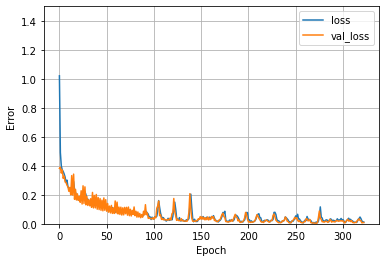

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Evaluate neural network

In [20]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

3/3 [==============================] - 0s 5ms/step - loss: 0.0086 - mse: 0.0086
loss test data:  0.008638673461973667
mse test data:  0.008638673461973667
3/3 [==============================] - 0s 4ms/step - loss: 0.0119 - mse: 0.0119
loss train data:  0.011946411803364754
mse train data:  0.011946411803364754


Plot results

<function matplotlib.pyplot.show>

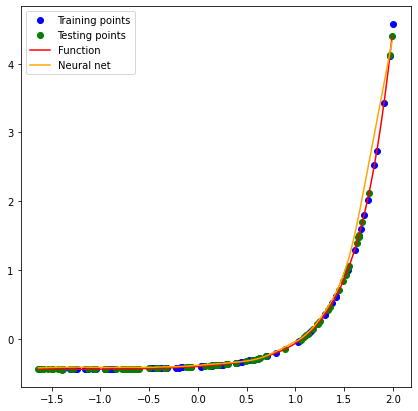

In [21]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show